### Generate the flavor evolution through the Sun, using as the matter potential the electron number density as a function of radius (Bahcall's BS05 solar model).  (2021nov10).

In [7]:
import scipy as sp
import numpy as np
from scipy.integrate import odeint
from scipy.special import exp10
import matplotlib.pyplot as plt
import math
import matplotlib
import cmath
import random
import os

%matplotlib inline

In [8]:
'Load the electron number density as a function of solar radius (n_e(r))-- this is output from Bahcalls model.'
'The equations of motion for flavor evolution will then take n_e(r) to be the matter potential term.'
#data = np.loadtxt('../solarNeutrinoModel/output_solarModel_bahcall.txt')
data = np.loadtxt('output_solarModel_Bahcall.txt')
print('bahcall radial step:', data[0,0])

'Define a bunch of parameters:'
N_A = 6.023e+23  # Avogadro's number
cl = 2.99792458e+5  # Speed of light in km/s
hbarc = 1.97326979e-16  # hbar*c in MeV.km
# n_e = N_A*exp10(data[:,2])*hbarc**3  # column of electron number densities (in MeV^3)
# Rsun = 6.957e+10/hbarc  # Radius of sun in MeV
# Gf = 1.166 * 10.**(-11) # Fermi coupling constant MeV**{-2}

n_e = N_A*exp10(data[:,2])*(1.0e+5)**3  # column of electron number densities (in km^{-3})
Rsun = 6.957e+5  # Radius of sun in km
Gf = 1.166 * 10.**(-11)*(hbarc)**2 # Fermi coupling constant in km^2
print(hbarc, Gf)

nestep = data[0,0]*Rsun

nuFlux_Be7 = data[:,10]   # column of Be7 channel
print('n_e: first and last=', n_e[0], n_e[-1])
print('nuFlux_Be7: first and last=', nuFlux_Be7[0], nuFlux_Be7[-1])
print('number of radial locations:', len(n_e))

print('mixing angle:', np.arcsin(np.sqrt(0.846))/2)  # according to amol's: sin**2(2theta) = 0.846 (+/- 0.021)

'''Add more entries to n_e so that I can increase the number of steps and not worry about the file being too short.'''
n_e_more = n_e[len(n_e)-1]*np.ones(50000)
print(len(n_e)+len(n_e_more))

neTot = []
tot = len(n_e)+len(n_e_more)
i = 0
while i < len(n_e):
    neTot.append(n_e[i])
    i += 1
#     while i < 50010:
#         neTot.append(0.062)
#         i += 1
while i < 50010:
    neTot.append(n_e[len(n_e)-1])
    i += 1
neTot = np.array(neTot)
print(len(neTot))
#print(neTot[-100:-1])
np.savetxt('ne_long.txt',neTot)

bahcall radial step: 0.00041
1.97326979e-16 4.540163412371666e-43
n_e: first and last= 6.206015603419852e+40 6.94724897185644e+38
nuFlux_Be7: first and last= 1.89e-06 1.732e-16
number of radial locations: 1219
mixing angle: 0.5837630475986898
51219
50010


dt: 2.8523699999999996
mixing angle: 0.5837630475986898
E1: 4.368383909632549e+16
E2: 1.9460086093954744e+16
dmsq: 1933846692847022.5
number of locations: 121901


<ipython-input-9-718bc3c27904>:89: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  self.times = sp.arange(0.,self.Tfinal+self.dt,self.dt)
<ipython-input-9-718bc3c27904>:104: DeprecationWarning: scipy.column_stack is deprecated and will be removed in SciPy 2.0.0, use numpy.column_stack instead
  sp.savetxt('%s/sim_%s.txt' % (self.path, self.label),sp.column_stack((self.times,self.sim)))
<ipython-input-9-718bc3c27904>:104: DeprecationWarning: scipy.savetxt is deprecated and will be removed in SciPy 2.0.0, use numpy.savetxt instead
  sp.savetxt('%s/sim_%s.txt' % (self.path, self.label),sp.column_stack((self.times,self.sim)))
<ipython-input-9-718bc3c27904>:105: DeprecationWarning: scipy.savetxt is deprecated and will be removed in SciPy 2.0.0, use numpy.savetxt instead
  sp.savetxt('%s/times_%s.txt' % (self.path, self.label), self.times)
<ipython-input-9-718bc3c27904>:106: DeprecationWarning: scipy.savetxt is deprecated and will

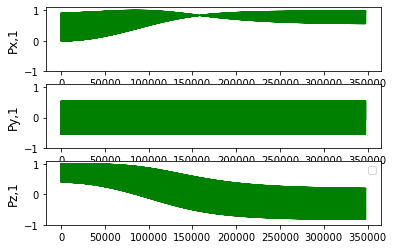

No handles with labels found to put in legend.


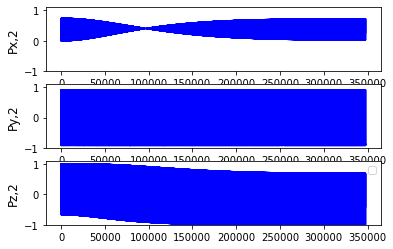

<ipython-input-9-718bc3c27904>:175: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111)


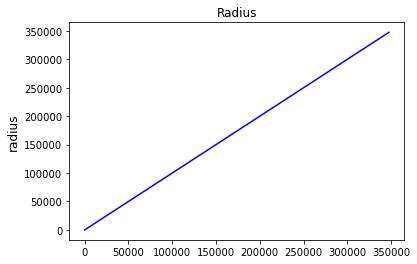

<ipython-input-9-718bc3c27904>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111)


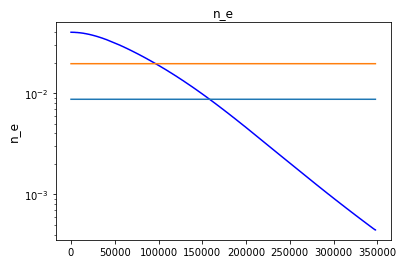

In [9]:
class network:
    def __init__(self):
        
        self.Date = '22jan25'  
        self.scaleFactor = 1. # To multiply matter potential.  Generally we just want this to be 1.
        self.Escale = 10. # To multiply the energies. Once we add the other beams, we can turn this back to 1.
                    # For now, we're artificially making it 10 because we're not yet using enough beams.
        self.FEWER = 1. # IF this value is less than 1, it means that we take fewer steps. For the 
                    # real experiments, we want this to be 1.

        '''Define initial conditions on flavor:'''
        self.Pz_1_init = 1. 
        self.Pz_2_init = 1.  

        self.path = ('VmattNonzero_kmUnits/allPoints/giveInitialization_withoutVmatt')
        if not os.path.exists(self.path):
            os.mkdir(self.path)
        self.label = ''
    
        '''Set ICs for the state variables: [P1,P2,P3,P4,P5,P6,r]
        OPTION 1: Begin from r=0:'''
        self.init = [0., 0., self.Pz_1_init, 0., 0., self.Pz_2_init, 0.]     

        '''Set discretization.'''
        self.dt = 1.0e-2*nestep # relative to Bahcall; units of R_sun.  
        print('dt:', self.dt)
        self.Tfinal = self.FEWER*self.dt*1219.*1.0e2 # integration window = step * number of steps.

        '''Define mixing angle, energies, delta m**2, G_f:'''
        self.theta = np.arcsin(np.sqrt(0.846))/2. 
        print('mixing angle:', self.theta)
        self.E1 = self.Escale*8.62*10**-1/hbarc # km^-1 
        self.E2 = self.Escale*3.84*10**-1/hbarc # km^-1
        print('E1:', self.E1)
        print('E2:', self.E2)

        self.dmsq = 7.53*10**(-17)/hbarc**2 # km^-2
        print('dmsq:', self.dmsq)
        
        self.delta_vac1 = self.dmsq/(2*self.E1) # km^-1.  delta m**2/(2E)
        self.delta_vac2 = self.dmsq/(2*self.E2) # km^-1
        
        '''Load n_e column from Bahcall'''
#        self.inj1 = np.loadtxt('ne_long.txt')  # This is artificially longer, to cover more than 1219 steps if desired.
#        self.injScale = 1.  
#        self.injdt = self.dt # one-to-one injection:step

        
    '''Piecewise linear interpolation, so that we can "inject" the model with Bahcalls n_e(r):'''
    def Iinj(self, t, Ivalue, step): 
        idx = int(t/step)
        if idx == t/step:
            return Ivalue[idx]
        else:
            slope = (Ivalue[idx+1]-Ivalue[idx])/step               
            return Ivalue[idx] + slope*(t-idx*step)    
        
    '''Define matter potential, which takes the "injection" of n_e(r):'''
    # V_matter depends on the n_e(r) from Bahcall's paper, and the parameter G_f defined above: 
    def V_matter(self,t): return self.scaleFactor*np.sqrt(2.)*Gf*self.Iinj(t,neTot,nestep)    
    

    '''Define model equations of motion:'''    
    def eqns(self,X, t): 
        P1x, P1y, P1z, P2x, P2y, P2z, r = X

        ### NEUTRINO 1 at Energy 1 ###
        dP1xdt = (self.delta_vac1*np.cos(2.0*self.theta) - self.V_matter(t))*P1y
 
        dP1ydt = (-self.delta_vac1*np.cos(2.0*self.theta) + self.V_matter(t))*P1x \
                  - self.delta_vac1*np.sin(2.0*self.theta)*P1z
op
        dP1zdt = self.delta_vac1*np.sin(2.0*self.theta)*P1y
        
        ### NEUTRINO 2 at Energy 2 ###
        dP2xdt = (self.delta_vac2*np.cos(2.0*self.theta) - self.V_matter(t))*P2y
        
        dP2ydt = (-self.delta_vac2*np.cos(2.0*self.theta) + self.V_matter(t))*P2x \
                  - self.delta_vac2*np.sin(2.0*self.theta)*P2z
            
        dP2zdt = self.delta_vac2*np.sin(2.0*self.theta)*P2y
        
        drdt = 1
               
        return dP1xdt, dP1ydt, dP1zdt, dP2xdt, dP2ydt, dP2zdt, drdt

    def DoIt(self):

        self.times = sp.arange(0.,self.Tfinal+self.dt,self.dt)
        print('number of locations:', len(self.times))

        '''JUst for plotting and saving V_matter as a function of r:'''
        self.Vmarr = np.zeros(len(self.times))
        j = 0
        while j < len(self.times):
            self.Vmarr[j] = self.V_matter(self.times[j])
            j += 1
            
            
        '''Run the simulation:'''
        self.sim = odeint(self.eqns,self.init,self.times)  # Integrate.
                
        '''Save stuff:'''
        sp.savetxt('%s/sim_%s.txt' % (self.path, self.label),sp.column_stack((self.times,self.sim)))
        sp.savetxt('%s/times_%s.txt' % (self.path, self.label), self.times)
        sp.savetxt('%s/P1x_%s.txt' % (self.path, self.label),self.sim[:,0])        
        sp.savetxt('%s/P1y_%s.txt' % (self.path, self.label),self.sim[:,1])        
        sp.savetxt('%s/P1z_%s.txt' % (self.path, self.label),self.sim[:,2])
        sp.savetxt('%s/P2x_%s.txt' % (self.path, self.label),self.sim[:,3])        
        sp.savetxt('%s/P2y_%s.txt' % (self.path, self.label),self.sim[:,4])        
        sp.savetxt('%s/P2z_%s.txt' % (self.path, self.label),self.sim[:,5]) 
        sp.savetxt('%s/r_%s.txt' % (self.path, self.label),self.sim[:,6]) 
        sp.savetxt('%s/Vmatt_%s.txt' % (self.path, self.label), self.Vmarr)
        # M does not contain Vmatt:
#        M = sp.column_stack((self.sim[:,0],self.sim[:,1],self.sim[:,2],self.sim[:,3],self.sim[:,4],self.sim[:,5],self.sim[:,6]))
        # M contains Vmatt:
#        M = sp.column_stack((self.sim[:,0],self.sim[:,1],self.sim[:,2],self.sim[:,3],self.sim[:,4],self.sim[:,5],self.sim[:,6],self.Vmarr))
#        np.savetxt('%s/init_trueSolution.dat' % (self.path),M)
#        np.savetxt('%s/init_trueSolution_Pz1IC%0.2f_Pz2IC%0.2f_N%i.dat' % (self.path, self.Pz_1_init, self.Pz_2_init, self.Nlocations),M)    


        '''Plot stuff:'''
        sim = self.sim
        times = self.times
        ymin, ymax = -1., 1.1
        alpha = 1.

        fig0 = plt.figure(0)
#        fig2.subplots_adjust(hspace=1.0)
        plt.title('Neutrino 1')
        plt.subplot(311)
        plt.ylim((ymin,ymax))
        plt.ylabel('Px,1', fontsize=12)
        plt.plot(times,sim[:,0],'g')#,linestyle='dotted') 
#        plt.legend()
        plt.subplot(312)
        plt.ylim((ymin,ymax))
        plt.ylabel('Py,1', fontsize=12)
        plt.plot(times,sim[:,1],'g')#,linestyle='dotted') 
#        plt.legend()
        plt.subplot(313)
        plt.ylim((ymin,ymax))
        plt.ylabel('Pz,1', fontsize=12)
        plt.plot(times,sim[:,2],'g') 
#        plt.scatter(times,Boundaries_nu1_array,s=2,c='m',alpha=alpha,label='Measurement locations')
        plt.legend()
        plt.show()
        fig0.savefig('%s/P1P2P3_%s.png' % (self.path, self.label))        
    
        fig1 = plt.figure(1)
        plt.ylim([-1.5,1.5])
#        fig3.subplots_adjust(hspace=1.0)
        plt.title('Neutrino 2')
        plt.subplot(311)
        plt.ylim((ymin,ymax))
        plt.ylabel('Px,2', fontsize=12)
        plt.plot(times,sim[:,3],'b')#,linestyle='dotted') 
#        plt.legend()
        plt.subplot(312)
        plt.ylim((ymin,ymax))
        plt.ylabel('Py,2', fontsize=12)
        plt.plot(times,sim[:,4],'b')#,linestyle='dotted') 
#        plt.legend()
        plt.subplot(313)
        plt.ylim((ymin,ymax))
        plt.ylabel('Pz,2', fontsize=12)
        plt.plot(times,sim[:,5],'b') 
#        plt.scatter(times,Boundaries_nu2_array,s=2,c='m',alpha=alpha,label="Measurement locations")
        plt.legend()
        plt.show()
        fig1.savefig('%s/P4P5P6_%s.png' % (self.path, self.label))           

        fig2 = plt.figure(2)
        plt.title('Radius')
        plt.subplot(111)
        plt.ylabel('radius', fontsize=12)
        plt.plot(times,sim[:,6],'b') 
#        plt.legend()
        plt.show()
        fig2.savefig('%s/radius_%s.png' % (self.path, self.label))    

        
        fig3 = plt.figure(3)
        plt.title('n_e')
        plt.subplot(111)
        plt.ylabel('n_e', fontsize=12)
        plt.yscale("log")
        plt.plot(times,self.Vmarr,'b') 
        plt.plot(times,np.ones_like(times)*self.delta_vac1*np.cos(2.0*self.theta))
        plt.plot(times,np.ones_like(times)*self.delta_vac2*np.cos(2.0*self.theta))
#        plt.legend()
        plt.show()
        fig3.savefig('%s/density_%s.png' % (self.path, self.label))    

        
#        fig3 = plt.figure(3)
#        plt.title('Heaviside for neutrinospheres')
#        plt.subplot(211)
#        plt.ylabel('heaviside nu1')
#        plt.plot(times,self.heaviside(self.r_nu1,self.T1,sim[:,6]),'g')
#        plt.subplot(212)
#        plt.ylabel('heaviside nu2')
#        plt.plot(times,self.heaviside(self.r_nu2,self.T2,sim[:,6]),'b')
#        plt.show()
#        fig3.savefig('%s/heaviside_nuspheres_%s.png' % (self.path, self.label))    
        
if __name__ == '__main__':

    net1 = network()
    net1.DoIt()   # Run the simulation
#    net1.plotNew()  # Plot P1, P2, P3, P4, P5, P6, r1, r2



In [1]:
import os
os.system("cp VmattNonzero_kmUnits/allPoints/giveInitialization_withoutVmatt/P*z*_.txt %s" %(os.getcwd()))
os.system("cp VmattNonzero_kmUnits/allPoints/giveInitialization_withoutVmatt/sim_*.txt %s" %(os.getcwd()))
os.system("cp VmattNonzero_kmUnits/allPoints/giveInitialization_withoutVmatt/Vmatt_*.txt /%s" %(os.getcwd()))
os.system("cp VmattNonzero_kmUnits/allPoints/giveInitialization_withoutVmatt/r_*.txt /%s" %(os.getcwd()))

1